In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv("nlpdisastertweets/train.csv")
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


So there are some tweets in the "text" column, and some targets, based on whether they are disasters or not. We can do some feature engineering on like whether there's disaster keywords with # or whatever. We should do some EDA. 

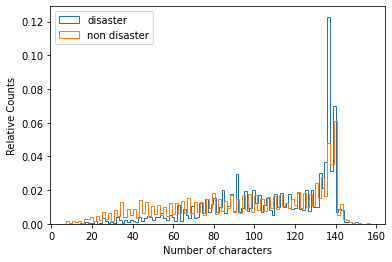

In [124]:
#Most obvious thing is tweet length. 
#I would expect that true disaster tweets are shorter, due to their immediate emergency status.
#Let's check
disastertweetlens = np.array([len(tweet) for tweet in train[train.target ==1].text], dtype = 'float32')
nondisastertweetlens = np.array([len(tweet) for tweet in train[train.target ==0].text], dtype = 'float32')

#Normalizing the histogram so that the y axis is relative frequency and the two can be directly compared.
#Obviously the max number of characters in a tweet is fixed at 160 so it's a moot point to adjust those.
disasterweights = np.ones_like(disastertweetlens)/float(len(disastertweetlens))
nondisasterweights = np.ones_like(nondisastertweetlens)/float(len(nondisastertweetlens))



plt.hist(disastertweetlens, histtype = 'step', label = 'disaster', weights = disasterweights, bins = 100)
plt.hist(nondisastertweetlens, histtype='step', label = 'non disaster', weights = nondisasterweights, bins = 100)
plt.xlabel("Number of characters")
plt.ylabel("Relative Counts")
plt.legend(loc = 2)
plt.show()



As it turns out, you cannot purely cut on the number of characters... However, it seems that non disaster tweets are not as verbose. Perhaps information about the distribution itself could be a thing to train on. Maybe density estimation??

In [35]:
#First we focus on how the punctuation plays a role... 
#Because you'd imagine people have different #blahblah usage or tagging
import string
print(string.punctuation)
#Let's check number of occurances of each character in the strings
punctuations = string.punctuation

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


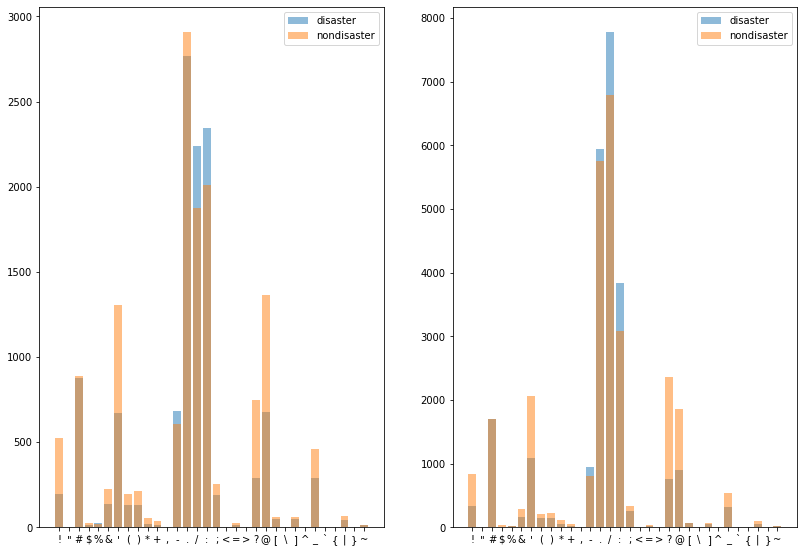

In [183]:
charsnondisaster = {}
charsnondisastercum = {}
for char in punctuations:
    count = 0
    countcum = 0
    for tweet in train[train.target == 0].text:
        if char in tweet:
            count += 1
        countcum += tweet.count(char)
    charsnondisaster[char] = count
    charsnondisastercum[char] = countcum

charsdisaster = {}
charsdisastercum = {}
for char in punctuations:
    count = 0
    countcum = 0
    for tweet in train[train.target == 1].text:
        if char in tweet:
            count += 1
        countcum += tweet.count(char)
    charsdisaster[char] = count
    charsdisastercum[char] = countcum


fig, ax = plt.subplots(1,2)
ax[0].bar(charsdisaster.keys(), [charsdisaster[key] for key in charsdisaster.keys()], label = 'disaster', alpha = 0.5)
ax[0].bar(charsnondisaster.keys(), [charsnondisaster[key] for key in charsnondisaster.keys()], label = 'nondisaster',alpha = 0.5)
ax[0].legend()

fig.tight_layout()
ax[1].bar(charsdisastercum.keys(), [charsdisastercum[key] for key in charsdisastercum.keys()], label = 'disaster', alpha = 0.5)
ax[1].bar(charsnondisastercum.keys(), [charsnondisastercum[key] for key in charsnondisastercum.keys()], label = 'nondisaster',alpha = 0.5)
ax[1].legend()
plt.subplots_adjust(left = 0.0001)
fig.set_size_inches(11, 8.5)

plt.show()

It is interesting that the use of "#" is the same in both disasters and nondisasters either way. People that use periods have more sentences in disasters than nondisasters. People seem to use multiple instances of "/" preferrentialy in disasters. There are some other insights as well. Time to check out the keywords and locations...

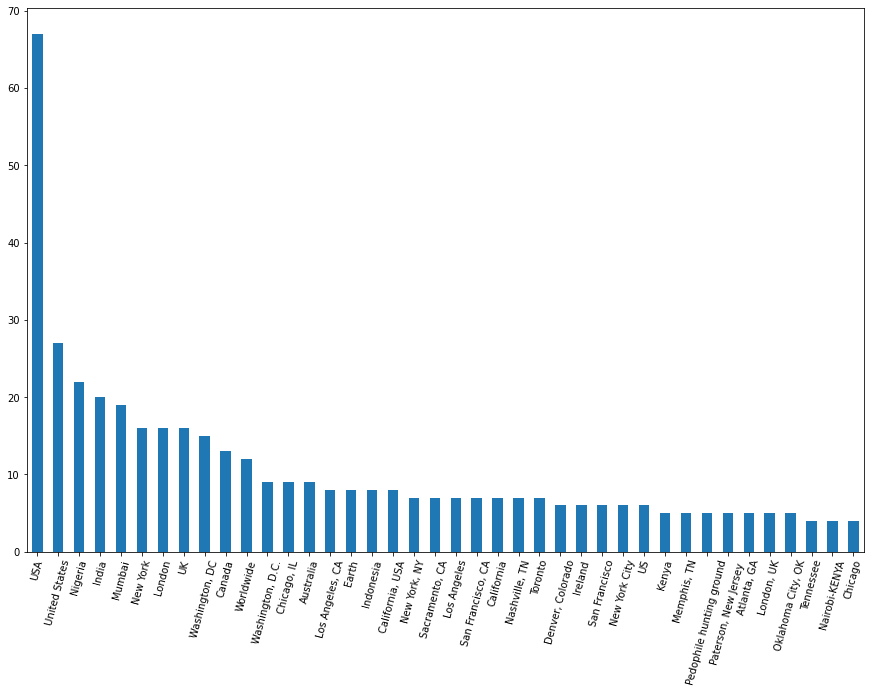

In [88]:
plt.figure(figsize = (15,10))
disasterlocs = train[train["target"]==1]["location"]
disasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Disaster Locations")
plt.show()

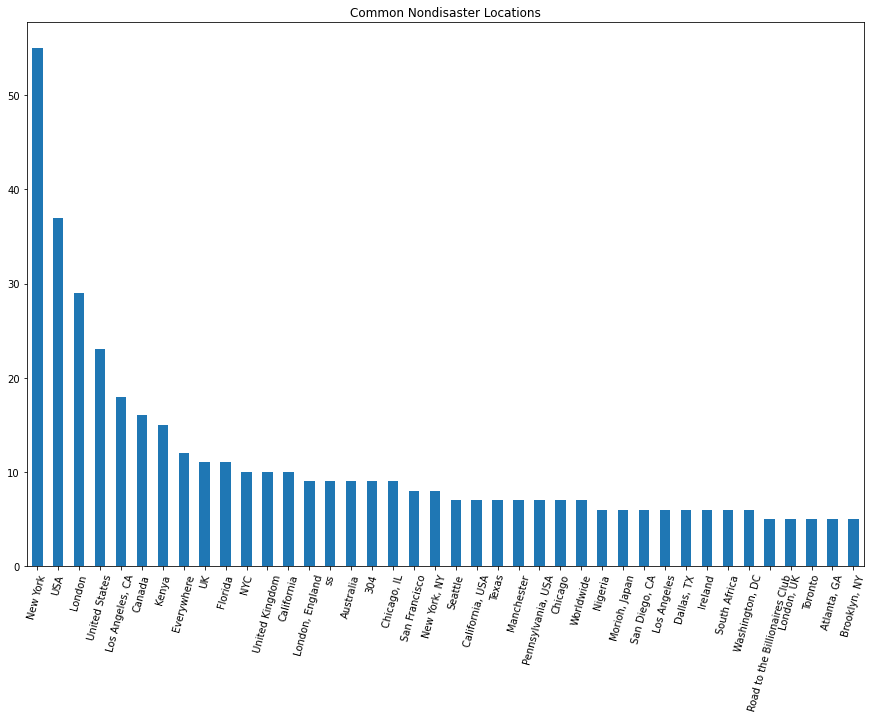

In [90]:
plt.figure(figsize = (15,10))
nondisasterlocs = train[train["target"]==0]["location"]
nondisasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Nondisaster Locations")
plt.show()

We'll do the same for the keywords

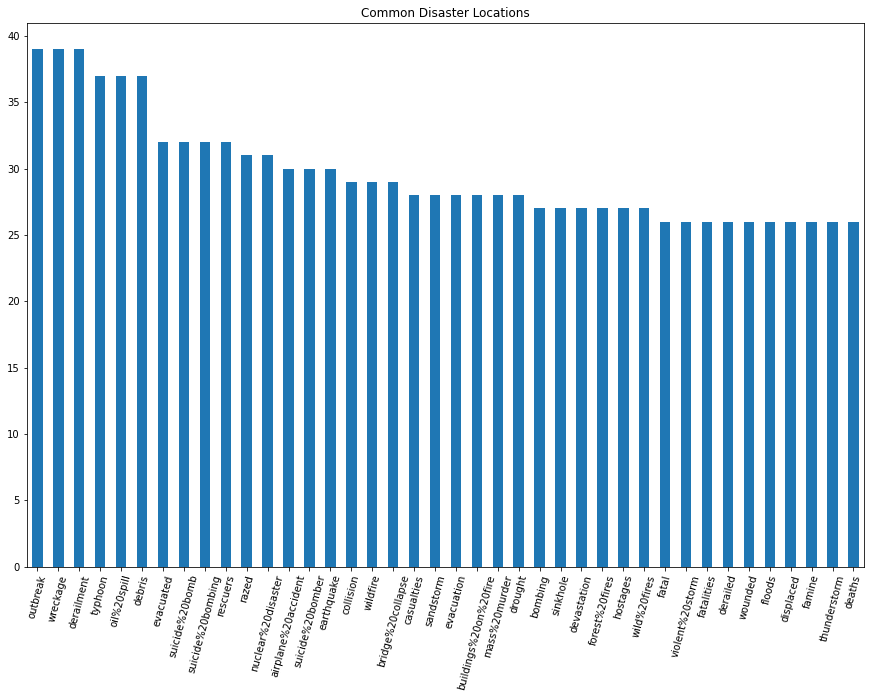

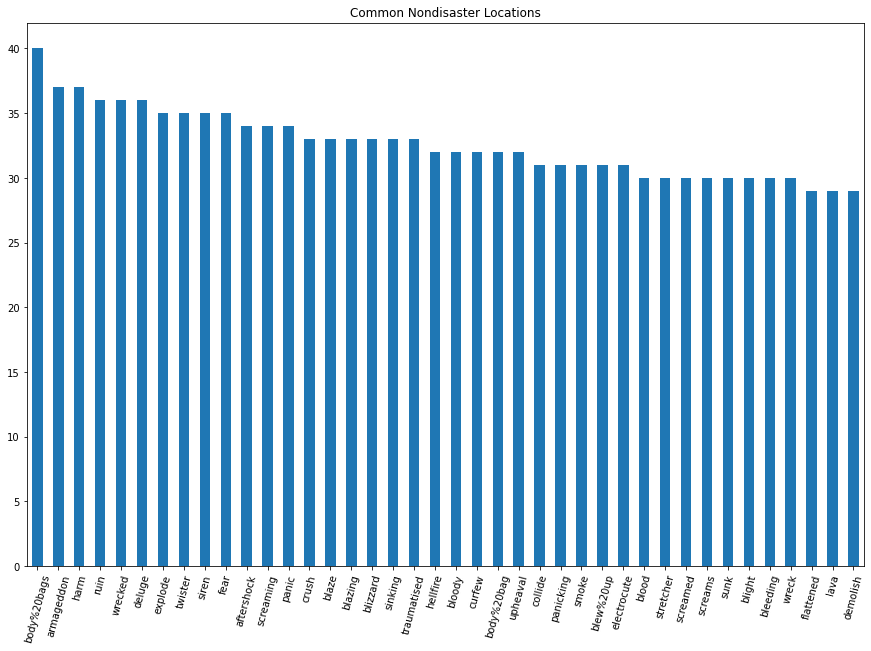

In [91]:
plt.figure(figsize = (15,10))
disasterlocs = train[train["target"]==1]["keyword"]
disasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Disaster Locations")
plt.show()

plt.figure(figsize = (15,10))
nondisasterlocs = train[train["target"]==0]["keyword"]
nondisasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Nondisaster Locations")
plt.show()

Now to clean data and design some high level features.